In [ ]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [44]:
import os
import glob
import tensorflow as tf
import numpy as np
from keras import backend, layers, models, optimizers, losses, metrics, regularizers
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K 

config = tf.ConfigProto(device_count={"CPU": 4})
backend.tensorflow_backend.set_session(tf.Session(config=config))

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

In [47]:
from keras.datasets import mnist

In [48]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.reshape([x_train.shape[0],28,28,1])
x_test.reshape([x_test.shape[0],28,28,1])
print ("done")

done


In [13]:
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

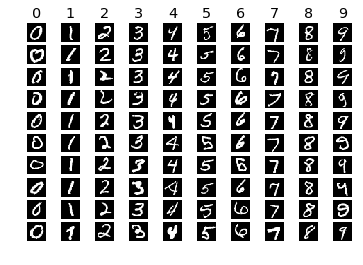

In [14]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

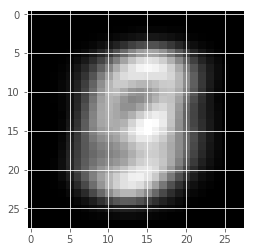

In [15]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((28,28)).astype('uint8'), cmap='gray') # визуализируем полученное среднее
plt.show()

In [16]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

x_train = x_train / 127.5
x_test = x_test / 127.5

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1000)

In [18]:
def build_encoder():
    img_input = layers.Input(shape=(28, 28, 1))
    
    x = layers.Conv2D(filters = 16,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(img_input)
    x = layers.Conv2D(filters = 32,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)    
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters = 32,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)  
    
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    
    x = layers.Conv2D(filters = 1,kernel_size=3,strides=(1,1),
                      padding='SAME',activation='relu')(x)  
    x = layers.Reshape([7*7*1])(x)
    x = layers.Dense(32)(x)
    output = x
    
    return models.Model(img_input, output, 
                        name='encoder')

In [19]:
def build_siamese():
    img_input = layers.Input(shape=(28, 28, 1))
    img_input_pair = layers.Input(shape=(28, 28, 1))
    encoder = build_encoder()
    
    embedding = encoder(img_input)
    embedding_pair = encoder(img_input_pair)
    
    output = layers.dot([embedding, embedding_pair], axes=-1, normalize=True)
    
    
    return models.Model([img_input, img_input_pair], output, 
                        name='siamese')

In [20]:
K.clear_session()
model = build_siamese()

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 32)           15937       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot)                     (None, 1)            0           encoder[1][0]                    
          

Тренировочный цикл

In [22]:
def generate_batch(data, labels, batch_size):
    indexes = np.arange(len(data))
    
    while True:
        batch_obj = []
        batch_pair_obj = []
        batch_label = []
        for _ in range(batch_size // 2):
            class_index = np.random.choice(labels, 1, replace=False)

            class_objects_indexes = indexes[labels == class_index]
            object_index, positive_index = np.random.choice(class_objects_indexes, 2, replace=False)
            

            batch_obj.append(data[object_index])
            batch_pair_obj.append(data[positive_index])
            batch_label.append(1)

            other_objects_indexes = indexes[labels != class_index]
            negative_index = np.random.choice(other_objects_indexes, 1, replace=False)

            batch_obj.append(data[object_index])
            batch_pair_obj.append(data[negative_index[0]])
            batch_label.append(-1)

        yield [np.expand_dims(batch_obj, -1), np.expand_dims(batch_pair_obj, -1)], np.array(batch_label)
    

In [23]:
generator = generate_batch(x_train, y_train, 64)
generator_val = generate_batch(x_val, y_val, 64)

In [24]:
# for item in generator:
#     print (item[0][1].shape)

In [25]:
adam = optimizers.Adam(lr=0.0001,amsgrad=True)
model.compile('adam', 'mse', metrics=['acc'])

In [26]:
model.fit_generator(generator=generator, 
                    steps_per_epoch= 6, 
                    epochs=24, 
                    validation_steps= 32, 
                    validation_data=generator_val, 
                    callbacks= [ReduceLROnPlateau(patience=6, monitor='loss', epsilon=0.01, verbose=1)])

C:\Users\Public\anaconda3\lib\site-packages\keras\callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/24
6/6 [==============================] - 6s 1s/step - loss: 1.0938 - acc: 0.1719 - val_loss: 0.9844 - val_acc: 0.2124
Epoch 2/24
6/6 [==============================] - 6s 1s/step - loss: 0.9313 - acc: 0.1615 - val_loss: 0.9151 - val_acc: 0.1309
Epoch 3/24
6/6 [==============================] - 6s 941ms/step - loss: 0.9011 - acc: 0.1536 - val_loss: 0.8883 - val_acc: 0.1606
Epoch 4/24
6/6 [==============================] - 6s 1s/step - loss: 0.9228 - acc: 0.1693 - val_loss: 0.8776 - val_acc: 0.1611
Epoch 5/24
6/6 [==============================] - 7s 1s/step - loss: 0.8309 - acc: 0.2031 - val_loss: 0.8685 - val_acc: 0.1577
Epoch 6/24
6/6 [==============================] - 6s 966ms/step - loss: 0.8314 - acc: 0.1458 - val_loss: 0.8035 - val_acc: 0.1836
Epoch 7/24
6/6 [==============================] - 6s 984ms/step - loss: 0.8447 - acc: 0.1823 - val_loss: 0.8322 - val_acc: 0.2275
Epoch 8/24
6/6 [==============================] - 6s 975ms/step - loss: 0.7923 - acc: 0.2734 - val_los

In [31]:
def retrieve(index):
    request = x_test[index]
    data = np.expand_dims(x_test, -1)
    
    scores = model.predict([data, np.array([data[index]] * len(data))], batch_size=128)
    
    scores = np.squeeze(scores)
    scores[index] = -100
    
    sort = np.argsort(scores * -1)
    
#     return sort
    
    fig = plt.figure()
    a=fig.add_subplot(1,3,1)
    imgplot = plt.imshow(x_test[index] * 127.5 + mean_image, cmap='gray')
    a.set_title('Request')
    a=fig.add_subplot(1,3,2)
    imgplot = plt.imshow(x_test[sort[0]]  * 127.5+ mean_image, cmap='gray')
    a.set_title(f'Result. Label {y_test[sort[0]]}')
    a=fig.add_subplot(1,3,3)
    imgplot = plt.imshow(x_test[sort[1]] * 127.5  + mean_image, cmap='gray')
    a.set_title(f'Result. Label {y_test[sort[1]]}')
    plt.show()


[[-0.62520444]
 [ 0.65202433]
 [-0.3398461 ]
 ..., 
 [-0.2043609 ]
 [ 0.68849021]
 [ 0.60337508]]


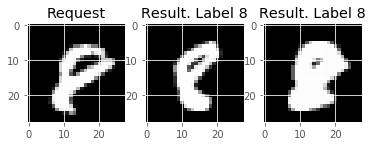

In [41]:
a = retrieve(242)